# Intro: Configurations

A configuration is essentially a tree of (coordinate) frames, where each frame can have an associated shape, joint, inertia, etc. This tutorial introduces first steps to creating & loading configurations in rai, setting/getting the joint and frame state, computing features, and handling the view window.

Please see the [Script:Configurations](https://marctoussaint.github.io/robotics-course/script/script.html#scene-robot-description) of configurations and degrees-of-freedom.

## Building a configuration from scratch

Let's first build a configuration from scratch by adding frames and setting properties such as pose, shape and parentship of frames.

In [1]:
import robotic as ry
import numpy as np
import time
print('version:', ry.__version__, ry.compiled())

version: 0.1.3b compile time: Jan 24 2024 12:00:54


The following creates an empty configuration, and opens a view window for it.

**Tip:** Make the view window appear "Always On Top" (right click on the window bar).

In [2]:
C = ry.Config()
C.view()

0

The `C.view()` command will open a window that shows an empty configuration. 

A configuration is essentially a tree (or forest) of frames. You usually add models from files, but let's do it manually here. We declare it a **marker** frame, which means it has no real shape, but is displayed using its base vectors in the view.

In [3]:
C.clear()
f = C.addFrame(name='first')
f.setShape(type=ry.ST.marker, size=[.3])
f.setPosition([0.,0.,.5])
f.setQuaternion([1., .3, .0, .0]) # more about quaternions below
print('frame name:', f.name, 'pos:', f.getPosition(), 'quat:', f.getQuaternion())
C.view()

frame name: first pos: [0.  0.  0.5] quat: [0.95782629 0.28734789 0.         0.        ]


0

Let's add a second frame, but with first as parent and with a hinge joint!

In [4]:
f = C.addFrame(name='second', parent='first')
f.setJoint(ry.JT.hingeX)
f.setShape(type=ry.ST.marker, size=[.4])
f.setColor([1,0,0])
print('frame name:', f.name, 'pos:', f.getPosition(), 'quat:', f.getQuaternion())
C.view()

frame name: second pos: [0.  0.  0.5] quat: [-0.95782629 -0.28734789 -0.         -0.        ]


0

Since we now have a configuration with a joint, we can articulate it:

In [5]:
q = C.getJointState()
q[0] = q[0] + .2
C.setJointState(q)
print('joint state:', q)
C.view()

joint state: [0.2]


0

For illustration, let's add various other child frames with shapes to the 'second' frame and animate it with a trivial loop:

In [6]:
# Add new frames: a box, a ball and a capsule
C.addFrame('ball', 'second') .setShape(ry.ST.sphere, [.1]) .setColor([1.,.5,.0]) .setRelativePosition([-.3,.0,.2])
C.addFrame('box', 'second') .setShape(ry.ST.ssBox, [.3,.2,.1,.02]) .setColor([.5,1.,.0]) .setRelativePosition([.0,.0,.2])
C.addFrame('capsule', 'second') .setShape(ry.ST.capsule, [.3, .05]) .setColor([.0,1.,.5]) .setRelativePosition([.3,.0,.2])

# Articulate the new configuration by moving the hinge joint
for t in range(50):
    C.setJointState([np.cos(.1*t)])
    C.view()
    time.sleep(.1)

The following lists all predefined shape types:

In [7]:
ry.ST.__members__.keys()

dict_keys(['none', 'box', 'sphere', 'capsule', 'mesh', 'cylinder', 'marker', 'pointCloud', 'ssCvx', 'ssBox', 'ssCylinder', 'ssBoxElip', 'quad', 'camera', 'sdf'])

For most of these, the `size` fully specifies them (box: 3 widths, sphere: radius, capsule: [length radius], cylinder: [length radius], marker: [axes lengths]). The `ssBox` is a sphere-swept-Box with a 4D size: [3 widths, corner radius], which is used a lot. Also mesh shapes can be set manually from python (`setMesh`) by directly giving vertex and triangle arrays. `ssCvx` means sphere-swept convex mesh, which is specified by a mesh and 1D size (radius), and also a very useful shape type.

Let's also briefly list the possible joint types:

In [8]:
ry.JT.__members__.keys()

dict_keys(['hingeX', 'hingeY', 'hingeZ', 'transX', 'transY', 'transZ', 'transXY', 'trans3', 'transXYPhi', 'transYPhi', 'universal', 'rigid', 'quatBall', 'phiTransXY', 'XBall', 'free', 'generic', 'tau'])

Please see the [Script:Kinematics](https://marctoussaint.github.io/robotics-course/script/script.html#kinematics) on the basics of such joints (=parameterized transformations). The `quatBall` perhaps deserves special explanation: it realizes a ball joint by introducing the 4D quaternion as joint state - this sometimes requires special attention. But the rai code implements correct Jacobians (accounting also for implicit normalization) w.r.t. the quaternion parameterization. The `free` joint is a 7D joint with 3D position and `quatBall`.

There is also a `rigid` joint, which simply means no DOF and seems fully redundant: having no joint or a rigid joint is the same. However, there is a semantic difference. A child frame without joint is really considered to be *a part* of the parent: The parent could be a *link* with multiple shapes (e.g. convex parts) or masses associated, but it is semantically one big link. When a frame has a joint (including a `rigid` joint), it is not considered part of its parent. That semantics rarely makes a difference, but it does in certain picking or walking scenarios, where objects, endeffectors or feet *attach* to other objects via a rigid joint.

## Specifying transformations: Quaternions & turtle strings

See the [Script:Transformations](https://marctoussaint.github.io/robotics-course/script/script.html#d-transformations-rotations-quaternions) on background on 3D transformations, rotations, and quaternions. We use the (w,x,y,z) convention for quaternions. Whenever you set a quaternion manually, it is internally normalized. So setting a quaterniong (1,1,0,0) is totally fine and means 90-degrees around x:

In [9]:
C.clear()
C.addFrame('A') .setShape(ry.ST.marker, [.3]) .setPosition([0.,0.,.5]) .setQuaternion([1., 1., .0, .0])
C.view()

0

But to specify transformations using translation and quaternion is not always intuitive as a human.
Therefore, we also allow for a *turtle string* notation, namely a string that 
chains little interpretable 'translate' and 'rotate' commands to define a 
transformation, as in the old turtle language. Here is an example:

In [10]:
C.clear()
f = C.addFrame('A') .setShape(ry.ST.marker, [.3])
f.setPose('t(0 0 .5) d(30 1 0 0) t(0 0 .5) d(30 1 0 0)') #t=translate, #d=rotate-by-degrees around axis
C.view()

0

Here is a specification of the possible commands:
<pre>
  t(x y z)       # translation by (x,y,z)
  q(q0 q1 q2 q3) # rotation by a quaternion
  r(r x y z)     # rotation by `r` _radians_ around the axis (x,y,z)
  d(d x y z)     # rotation by `d` _degrees_ around the axis (x,y,z)
  E(r p y)       # rotation by roll-pitch-yaw Euler angles
</pre>

## Loading existing configurations

You will usually load predefined configurations from file, and then perhaps edit and combine them manually. The rai package has several robot models predefined and installed in the `raiPath`. They typically have the `.g`-file extension (see [Script:gFiles](https://marctoussaint.github.io/robotics-course/script/script.html#graph-yaml-files) on this file format, which is a yaml-conform graph file). Converting from URDF to configuration files is possible (see advanced tutorial).

In [11]:
C.clear()
C.addFile(ry.raiPath('panda/panda.g'))
C.view()

0

Let's add a second panda, but to avoid frame name conflicts we prefix all frame names. That's often important when importing multiple models into a single configuration. We can then also move the second robot simply by redefining the position of its base frame.

In [12]:
C.addFile(ry.raiPath('panda/panda.g'), 'r_')
base_r = C.getFrame('r_panda_base')
base_r.setPosition([.0, .5, .0])
C.view()

0

These models have several joints. We can get the joint state of the full configuration:

In [13]:
print(C.getJointState())
print('joints:', C.getJointNames())
print('frames:', C.getFrameNames())

[ 0.   -1.    0.   -2.    0.    2.    0.    0.05  0.   -1.    0.   -2.
  0.    2.    0.    0.05]
joints: ['panda_joint1', 'panda_joint2', 'panda_joint3', 'panda_joint4', 'panda_joint5', 'panda_joint6', 'panda_joint7', 'panda_finger_joint1panda_finger_joint2', 'r_panda_joint1', 'r_panda_joint2', 'r_panda_joint3', 'r_panda_joint4', 'r_panda_joint5', 'r_panda_joint6', 'r_panda_joint7', 'r_panda_finger_joint1r_panda_finger_joint2']
frames: ['panda_base', 'panda_link0', 'panda_link0_0', 'panda_joint1_origin', 'panda_joint1', 'panda_link1', 'panda_link1_0', 'panda_joint2_origin', 'panda_joint2', 'panda_link2', 'panda_link2_0', 'panda_joint3_origin', 'panda_joint3', 'panda_link3', 'panda_link3_0', 'panda_joint4_origin', 'panda_joint4', 'panda_link4', 'panda_link4_0', 'panda_joint5_origin', 'panda_joint5', 'panda_link5', 'panda_link5_0', 'panda_joint6_origin', 'panda_joint6', 'panda_link6', 'panda_link6_0', 'panda_joint7_origin', 'panda_joint7', 'panda_link7', 'panda_link7_0', 'panda_joint8_or

Let's animate - without respect for limits or collisions! (E.g., the fingers go out of limits.)

In [14]:
q0 = C.getJointState()
for t in range(20):
    q = q0 + .1*np.random.randn(q0.shape[0])
    C.setJointState(q)
    C.view()
    time.sleep(.2)

## Features: computing geometric properties
For every frame we can query its pose:

In [15]:
f = C.getFrame('r_gripper')
print('gripper pos:', f.getPosition())
print('gripper quat:', f.getQuaternion())
print('gripper rot:', f.getRotationMatrix())

gripper pos: [0.22856772 0.47063579 0.85966532]
gripper quat: [-0.7795158  -0.20030506  0.49603135  0.32586178]
gripper rot: [[ 0.29553401  0.30931363 -0.90387208]
 [-0.70674399  0.70738396  0.01099339]
 [ 0.64278502  0.63555724  0.42766157]]


The above provides basic forward kinematics: After `setJointState` you can query the pose of any configuration frame.

However, there is a more general way to query *features* (see [Script:Features](https://marctoussaint.github.io/robotics-course/script/script.html#general-concept-of-differentiable-features)), i.e. properties of the configuration in a differentiable manner. You might not use this often; but it is important to understand as these differentiable features are the foundation of how optimization problems are formulated, which you will need a lot.

Here are some example features to evaluate:

In [16]:
[y,J] = C.eval(ry.FS.position, ['gripper'])
print('position of gripper:', y, '\nJacobian:', J)

position of gripper: [ 0.29015241 -0.04237736  0.81203804] 
Jacobian: [[ 4.23773563e-02  4.78453273e-01  2.19427933e-04 -2.53166380e-01
   5.01574944e-03  1.46177561e-02  1.73472348e-18  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.90152414e-01  2.36623723e-02  5.59283410e-01 -3.85704778e-02
   1.33030960e-01  2.51872516e-03 -1.38777878e-17  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.87704968e-01  4.93432314e-02  5.22810530e-01
  -1.72692446e-03  2.36482509e-01  5.20417043e-18  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [17]:
# negative(!) distance between two convex shapes (or origin of marker)
C.eval(ry.FS.negDistance, ['panda_coll7', 'r_panda_coll7'])

(array([-0.36498153]),
 array([[ 5.60749608e-02,  4.19598469e-02,  5.40770473e-01,
         -2.51573073e-02, -8.23140315e-02,  1.37291988e-03,
          1.38912410e-16, -0.00000000e+00, -6.80970822e-02,
          1.95029092e-02, -5.61570164e-01, -1.51899434e-02,
         -4.56799000e-03,  2.05355921e-03, -1.45302915e-16,
         -0.00000000e+00]]))

In [18]:
# the x-axis of the given frame in world coordinates
C.eval(ry.FS.vectorX, ['gripper'])

(array([ 0.2484337 , -0.76392054,  0.59557209]),
 array([[ 0.76392054,  0.59484507,  0.34981871, -0.64641655,  0.37433015,
         -0.58519029, -0.35018024,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.2484337 ,  0.02941864,  0.64014555, -0.02335735, -0.38529194,
          0.02565984, -0.64409405,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        , -0.21039612,  0.67517196,  0.23968299, -0.65034722,
          0.27701612, -0.68008577,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ]]))

## Joint and Frame State

A configuration is a tree of $n$ frames. Every frame has a pose (position & quaternion), which is represented as a 7D vector $(x,y,z, q_w,q_x,q_y,q_z)^T$. The frame state is the $n\times 7$ matrix, where the $i$-th row is the pose of the $i$-th frame.

A configuration also defines joints, which means that the relative transfromation from a parent to a child frame is parameterized by degrees-of-freedom (DOFs). If the configuration has in total $d$ DOFs, the joint state is a $d$-dimensional vector.

Setting the joint state implies computing all relative transformations, and then forward chaining all transformations to compute all frame poses. So setting the joint state also sets the frame state.
     
Setting the frame state allows you to set frame poses that are inconsistent/impossible w.r.t. the joints! Setting the frame state implies computing all relative transformations from the frame poses, and then assigning the joint state to the *projection* onto the actual DOFs

In [19]:
C.setJointState(q0)
C.view()

0

The *frame state* is a $n\times 7$ matrix, which contains for all of $n$ frames the 7D pose. A pose is stored as [p_x, p_y, p_z, q_w, q_x, q_y, q_z], with position p and quaternion q.

In [20]:
X0 = C.getFrameState()
print('frame state: ', X0)

frame state:  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.33000000e-01  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.33000000e-01  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.33000000e-01  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.33000000e-01  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.33000000e-01  7.07106781e-01
  -7.07106781e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.33000000e-01 

Let's do a very questionable thing: adding .1 to all numbers in the frame matrix!

In [21]:
X = X0 + .1
C.setFrameState(X)
C.view()

0

That totally broke the original design of the robot! Setting global frame states overwrites the relative transformations between frames.

(Also, the rows of X have non-normalized quaternions! These are normalized when setting the frame state.)

Let's reset:

In [22]:
C.setFrameState(X0)
C.view()

0

 ## Selecting joints

Often one would like to choose which joints are actually active, that is, which joints are referred to in q. This allows one to sub-select joints and work only with projections of the full configuration state. This changes the joint state dimensionality, including ordering of entries in q. The frame state is not affected by such a selection of active joints.

In [23]:
C.selectJoints(['panda_joint1', 'r_panda_joint1'])
print('joint state: ', C.getJointState())
print('joint names: ', C.getJointNames() )

joint state:  [0. 0.]
joint names:  ['panda_joint1', 'r_panda_joint1']


In [24]:
C.selectJoints([], notThose=True)
print('joint state: ', C.getJointState())
print('joint names: ', C.getJointNames() )

joint state:  [ 0.      -1.00001  0.      -2.00001  0.       2.00001  0.       0.05
  0.      -1.00001  0.      -2.00001  0.       2.00001  0.       0.05   ]
joint names:  ['panda_joint1', 'panda_joint2', 'panda_joint3', 'panda_joint4', 'panda_joint5', 'panda_joint6', 'panda_joint7', 'panda_finger_joint1panda_finger_joint2', 'r_panda_joint1', 'r_panda_joint2', 'r_panda_joint3', 'r_panda_joint4', 'r_panda_joint5', 'r_panda_joint6', 'r_panda_joint7', 'r_panda_finger_joint1r_panda_finger_joint2']


## View interaction and releasing objects

You can close and re-open the view window

In [25]:
C.view_close()

In [26]:
# things are still there
C.view(pause=False, message='this is a message')

0

For user interaction it is often useful to wait for a keypress (i.e., by making `view` a blocking call via `pause=True`):

In [27]:
pressed_key = C.view(pause=True, message='press some key!')
print('pressed key:', pressed_key, chr(pressed_key))

pressed key: 0  


As you can see above, `.view()` also returnes the ID of key that was pressed, which can be helpful for debugging purposes.

To visualize your configuration outside of the viewer, you can also get a screenshot:

In [28]:
img = C.view_getRgb()
print(type(img), img.shape)

<class 'numpy.ndarray'> (400, 400, 3)


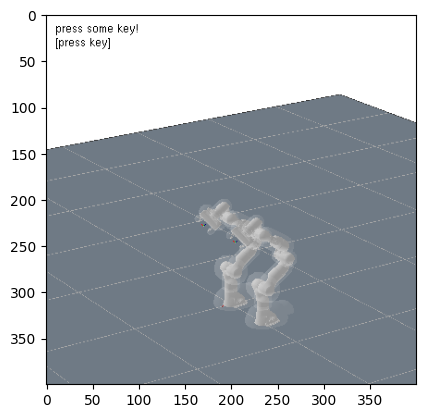

In [29]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

## Cleanup

Don't forget to release everything, including closing the view

In [30]:
del C